In [1]:

# ============================================
# CELL 1: SETUP
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported!")


✅ Libraries imported!


In [2]:
# ============================================
# CELL 2: LOAD DATA
# ============================================

df = pd.read_csv('../data/raw/college_mess_data.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Original shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Original shape: (894, 30)
Date range: 2024-01-01 00:00:00 to 2024-10-24 00:00:00


In [3]:
# ============================================
# CELL 3: TEMPORAL FEATURES
# ============================================

print("="*60)
print("CREATING TEMPORAL FEATURES")
print("="*60)

# Extract date components
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week_num'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['week_of_year'] = df['date'].dt.isocalendar().week

# Create binary flags
df['is_monday'] = (df['day_of_week_num'] == 0).astype(int)
df['is_friday'] = (df['day_of_week_num'] == 4).astype(int)

# Weekend already exists, but let's confirm
print(f"Weekend flag exists: {'is_weekend' in df.columns}")

# Cyclical encoding (important for ML!)
# Day of month (1-31)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

# Month (1-12)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Day of week (0-6)
df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week_num'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week_num'] / 7)

print(f"✅ Created {6 + 6} temporal features")
print("\nNew temporal features:")
print(df[['date', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']].head(3))

CREATING TEMPORAL FEATURES
Weekend flag exists: True
✅ Created 12 temporal features

New temporal features:
        date   day_sin  day_cos  month_sin  month_cos  dow_sin  dow_cos
0 2024-01-01  0.201299  0.97953        0.5   0.866025      0.0      1.0
1 2024-01-01  0.201299  0.97953        0.5   0.866025      0.0      1.0
2 2024-01-01  0.201299  0.97953        0.5   0.866025      0.0      1.0


In [4]:
# ============================================
# CELL 4: LAG FEATURES (Based on EDA - yesterday matters!)
# ============================================

print("\n" + "="*60)
print("CREATING LAG FEATURES")
print("="*60)

# Sort by date and meal type (important!)
df = df.sort_values(['date', 'meal_type']).reset_index(drop=True)

# Lag features by meal type (breakfast depends on yesterday's breakfast)
for lag in [1, 7, 14]:  # Yesterday, last week, 2 weeks ago
    df[f'students_lag_{lag}'] = df.groupby('meal_type')['students_attended'].shift(lag)
    df[f'waste_lag_{lag}'] = df.groupby('meal_type')['food_wasted_kg'].shift(lag)
    print(f"✅ Created lag-{lag} features")

# Last week same day same meal (very predictive!)
df['students_same_day_last_week'] = df.groupby(['meal_type', 'day_of_week'])['students_attended'].shift(1)

print(f"\n✅ Created {7} lag features")
print(f"⚠️ First few rows will have NaN (expected)")


CREATING LAG FEATURES
✅ Created lag-1 features
✅ Created lag-7 features
✅ Created lag-14 features

✅ Created 7 lag features
⚠️ First few rows will have NaN (expected)


In [5]:
# ============================================
# CELL 5: ROLLING/MOVING AVERAGES
# ============================================

print("\n" + "="*60)
print("CREATING ROLLING STATISTICS")
print("="*60)

# Rolling averages (trend indicators)
for window in [3, 7, 14]:
    df[f'students_roll_{window}d_mean'] = df.groupby('meal_type')['students_attended'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )
    df[f'students_roll_{window}d_std'] = df.groupby('meal_type')['students_attended'].transform(
        lambda x: x.rolling(window=window, min_periods=1).std()
    )
    print(f"✅ Created {window}-day rolling features")

# Rolling max/min (recent extremes)
df['students_roll_7d_max'] = df.groupby('meal_type')['students_attended'].transform(
    lambda x: x.rolling(window=7, min_periods=1).max()
)
df['students_roll_7d_min'] = df.groupby('meal_type')['students_attended'].transform(
    lambda x: x.rolling(window=7, min_periods=1).min()
)

print(f"\n✅ Created 8 rolling statistics features")


CREATING ROLLING STATISTICS
✅ Created 3-day rolling features
✅ Created 7-day rolling features
✅ Created 14-day rolling features

✅ Created 8 rolling statistics features


In [6]:
# ============================================
# CELL 6: INTERACTION FEATURES (Based on EDA insights!)
# ============================================

print("\n" + "="*60)
print("CREATING INTERACTION FEATURES")
print("="*60)

# Your EDA showed these matter together!

# Weekend × Exam (both reduce attendance)
df['weekend_x_exam'] = df['is_weekend'].astype(int) * df['is_exam_period'].astype(int)

# Weekend × Festival (compound effect)
df['weekend_x_festival'] = df['is_weekend'].astype(int) * df['is_festival'].astype(int)

# Rainy × Weekend (rainy days increase attendance, but weekend decreases)
df['rainy_x_weekend'] = (df['weather'] == 'Rainy').astype(int) * df['is_weekend'].astype(int)

# Exam × Festival (rarely happen together, but if they do...)
df['exam_x_festival'] = df['is_exam_period'].astype(int) * df['is_festival'].astype(int)

# Menu popularity × weekend (popular items on weekends?)
df['popularity_x_weekend'] = df['menu_popularity'] * df['is_weekend'].astype(int)

# Temperature × Rainy (cold rainy days)
df['temp_x_rainy'] = df['temperature_c'] * (df['weather'] == 'Rainy').astype(int)

print(f"✅ Created 6 interaction features")
print("\nInteraction features:")
print(df[['weekend_x_exam', 'weekend_x_festival', 'rainy_x_weekend']].head())


CREATING INTERACTION FEATURES
✅ Created 6 interaction features

Interaction features:
   weekend_x_exam  weekend_x_festival  rainy_x_weekend
0               0                   0                0
1               0                   0                0
2               0                   0                0
3               0                   0                0
4               0                   0                0


In [7]:
# ============================================
# CELL 7: MENU-BASED FEATURES
# ============================================

print("\n" + "="*60)
print("CREATING MENU-BASED FEATURES")
print("="*60)

# Menu popularity already exists, but let's add more

# Menu frequency (how often has this menu appeared recently?)
df['menu_count_last_7days'] = df.groupby('menu_item').cumcount()

# Average attendance for each menu item (historical performance)
menu_avg = df.groupby('menu_item')['students_attended'].mean()
df['menu_historical_avg'] = df['menu_item'].map(menu_avg)

# Menu variability (is attendance for this menu consistent?)
menu_std = df.groupby('menu_item')['students_attended'].std()
df['menu_historical_std'] = df['menu_item'].map(menu_std)

# Is this a "popular menu day"? (from EDA: Biryani, Chole-Bhature, etc.)
popular_items = ['Biryani', 'Chole-Bhature', 'Rice-Chicken', 'Puri-Bhaji', 'Dosa']
df['is_popular_menu'] = df['menu_item'].isin(popular_items).astype(int)

# Is this an unpopular menu day?
unpopular_items = ['Khichdi', 'Rice-Curd-Pickle', 'Upma']
df['is_unpopular_menu'] = df['menu_item'].isin(unpopular_items).astype(int)

print(f"✅ Created 5 menu-based features")


CREATING MENU-BASED FEATURES
✅ Created 5 menu-based features


In [8]:
# ============================================
# CELL 8: AGGREGATE FEATURES
# ============================================

print("\n" + "="*60)
print("CREATING AGGREGATE FEATURES")
print("="*60)

# Daily total attendance (all three meals)
daily_total = df.groupby('date')['students_attended'].sum()
df['daily_total_attendance'] = df['date'].map(daily_total)

# Daily average attendance
daily_avg = df.groupby('date')['students_attended'].mean()
df['daily_avg_attendance'] = df['date'].map(daily_avg)

# Percentage of daily attendance this meal represents
df['pct_of_daily_attendance'] = (df['students_attended'] / df['daily_total_attendance'] * 100)

# Weekly total/average
df['week_year'] = df['date'].dt.strftime('%Y-%W')
weekly_avg = df.groupby('week_year')['students_attended'].mean()
df['weekly_avg_attendance'] = df['week_year'].map(weekly_avg)

print(f"✅ Created 4 aggregate features")


CREATING AGGREGATE FEATURES
✅ Created 4 aggregate features


In [9]:
# ============================================
# CELL 9: SPECIAL EVENT COMBINATIONS
# ============================================

print("\n" + "="*60)
print("CREATING SPECIAL EVENT FEATURES")
print("="*60)

# Count of special conditions (how many special things happening?)
df['special_conditions_count'] = (
    df['is_exam_period'].astype(int) + 
    df['is_festival'].astype(int) + 
    df['is_weekend'].astype(int) +
    df['is_start_semester'].astype(int) +
    df['is_end_semester'].astype(int)
)

# Any special condition?
df['has_special_condition'] = (df['special_conditions_count'] > 0).astype(int)

# No special conditions (normal day)
df['is_normal_day'] = (df['special_conditions_count'] == 0).astype(int)

print(f"✅ Created 3 special event features")
print("\nSpecial conditions distribution:")
print(df['special_conditions_count'].value_counts().sort_index())


CREATING SPECIAL EVENT FEATURES
✅ Created 3 special event features

Special conditions distribution:
special_conditions_count
0    516
1    288
2     78
3     12
Name: count, dtype: int64


In [10]:
# ============================================
# CELL 10: RATIO & DERIVED FEATURES
# ============================================

print("\n" + "="*60)
print("CREATING RATIO FEATURES")
print("="*60)

# Attendance rate (already exists, but let's verify)
print(f"Attendance rate exists: {'attendance_rate' in df.columns}")

# Deviation from meal-type average
meal_avg = df.groupby('meal_type')['students_attended'].mean()
df['meal_type_avg'] = df['meal_type'].map(meal_avg)
df['deviation_from_meal_avg'] = df['students_attended'] - df['meal_type_avg']
df['pct_deviation_from_meal_avg'] = (df['deviation_from_meal_avg'] / df['meal_type_avg'] * 100)

# Deviation from day-of-week average
dow_avg = df.groupby('day_of_week')['students_attended'].mean()
df['dow_avg'] = df['day_of_week'].map(dow_avg)
df['deviation_from_dow_avg'] = df['students_attended'] - df['dow_avg']

# Temperature deviation from mean
temp_mean = df['temperature_c'].mean()
df['temp_deviation'] = df['temperature_c'] - temp_mean

print(f"✅ Created 6 ratio/deviation features")


CREATING RATIO FEATURES
Attendance rate exists: True
✅ Created 6 ratio/deviation features


In [11]:
# ============================================
# CELL 11: FEATURE SUMMARY
# ============================================

print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

original_features = 28  # Approximate from original data
new_features = len(df.columns) - original_features

print(f"\nOriginal features: {original_features}")
print(f"New features created: {new_features}")
print(f"Total features now: {len(df.columns)}")

print("\n📊 Feature Categories Created:")
print(f"   • Temporal features: 12")
print(f"   • Lag features: 7")
print(f"   • Rolling statistics: 8")
print(f"   • Interaction features: 6")
print(f"   • Menu features: 5")
print(f"   • Aggregate features: 4")
print(f"   • Special event features: 3")
print(f"   • Ratio features: 6")
print(f"   ─────────────────────────")
print(f"   Total new features: {12+7+8+6+5+4+3+6}")

print("\n⚠️ Features with missing values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0].sort_values(ascending=False))
else:
    print("   None (good!)")


FEATURE ENGINEERING SUMMARY

Original features: 28
New features created: 51
Total features now: 79

📊 Feature Categories Created:
   • Temporal features: 12
   • Lag features: 7
   • Rolling statistics: 8
   • Interaction features: 6
   • Menu features: 5
   • Aggregate features: 4
   • Special event features: 3
   • Ratio features: 6
   ─────────────────────────
   Total new features: 51

⚠️ Features with missing values:
students_lag_14                42
waste_lag_14                   42
students_same_day_last_week    21
students_lag_7                 21
waste_lag_7                    21
students_lag_1                  3
waste_lag_1                     3
students_roll_3d_std            3
students_roll_7d_std            3
students_roll_14d_std           3
dtype: int64


In [12]:
# ============================================
# CELL 12: HANDLE MISSING VALUES
# ============================================

print("\n" + "="*60)
print("HANDLING MISSING VALUES")
print("="*60)

# Check missing values before
print("Missing values before:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Drop rows where lag features are NaN (first few rows)
# This is expected and acceptable
initial_rows = len(df)
df = df.dropna()
final_rows = len(df)

print(f"\n✅ Removed {initial_rows - final_rows} rows with NaN (first few days)")
print(f"✅ Final dataset: {final_rows} rows")

# Verify no missing values
assert df.isnull().sum().sum() == 0, "Still have missing values!"
print("✅ No missing values remaining!")


HANDLING MISSING VALUES
Missing values before:
students_lag_1                  3
waste_lag_1                     3
students_lag_7                 21
waste_lag_7                    21
students_lag_14                42
waste_lag_14                   42
students_same_day_last_week    21
students_roll_3d_std            3
students_roll_7d_std            3
students_roll_14d_std           3
dtype: int64

✅ Removed 42 rows with NaN (first few days)
✅ Final dataset: 852 rows
✅ No missing values remaining!


In [13]:
# ============================================
# CELL 13: SAVE PROCESSED DATA
# ============================================

print("\n" + "="*60)
print("SAVING PROCESSED DATA")
print("="*60)

# Create processed directory if doesn't exist
import os
os.makedirs('../data/processed', exist_ok=True)

# Save with all features
output_file = '../data/processed/mess_data_with_features.csv'
df.to_csv(output_file, index=False)

print(f"✅ Saved processed data to: {output_file}")
print(f"   Shape: {df.shape}")
print(f"   Features: {len(df.columns)}")

# Also save feature names for later use
feature_cols = [col for col in df.columns if col not in ['date', 'menu_item', 'day_of_week', 'weather', 'meal_type', 'week_year']]

with open('../data/processed/feature_names.txt', 'w') as f:
    for feat in feature_cols:
        f.write(f"{feat}\n")

print(f"✅ Saved feature names to: feature_names.txt")


SAVING PROCESSED DATA
✅ Saved processed data to: ../data/processed/mess_data_with_features.csv
   Shape: (852, 79)
   Features: 79
✅ Saved feature names to: feature_names.txt



QUICK FEATURE IMPORTANCE CHECK

🏆 Top 20 Most Important Features:
                    feature  importance
pct_deviation_from_meal_avg    0.672658
     deviation_from_dow_avg    0.157493
    deviation_from_meal_avg    0.090063
              meal_type_avg    0.022532
               meal_encoded    0.017929
                    dow_avg    0.009500
      students_roll_7d_mean    0.007994
                    dow_sin    0.003024
       daily_avg_attendance    0.002935
       students_roll_7d_min    0.002027
        menu_historical_avg    0.001987
     daily_total_attendance    0.001980
    pct_of_daily_attendance    0.001630
       students_roll_7d_max    0.001459
            day_of_week_num    0.001144
        menu_historical_std    0.001046
            students_lag_14    0.000389
students_same_day_last_week    0.000322
                 is_weekend    0.000319
     students_roll_14d_mean    0.000301


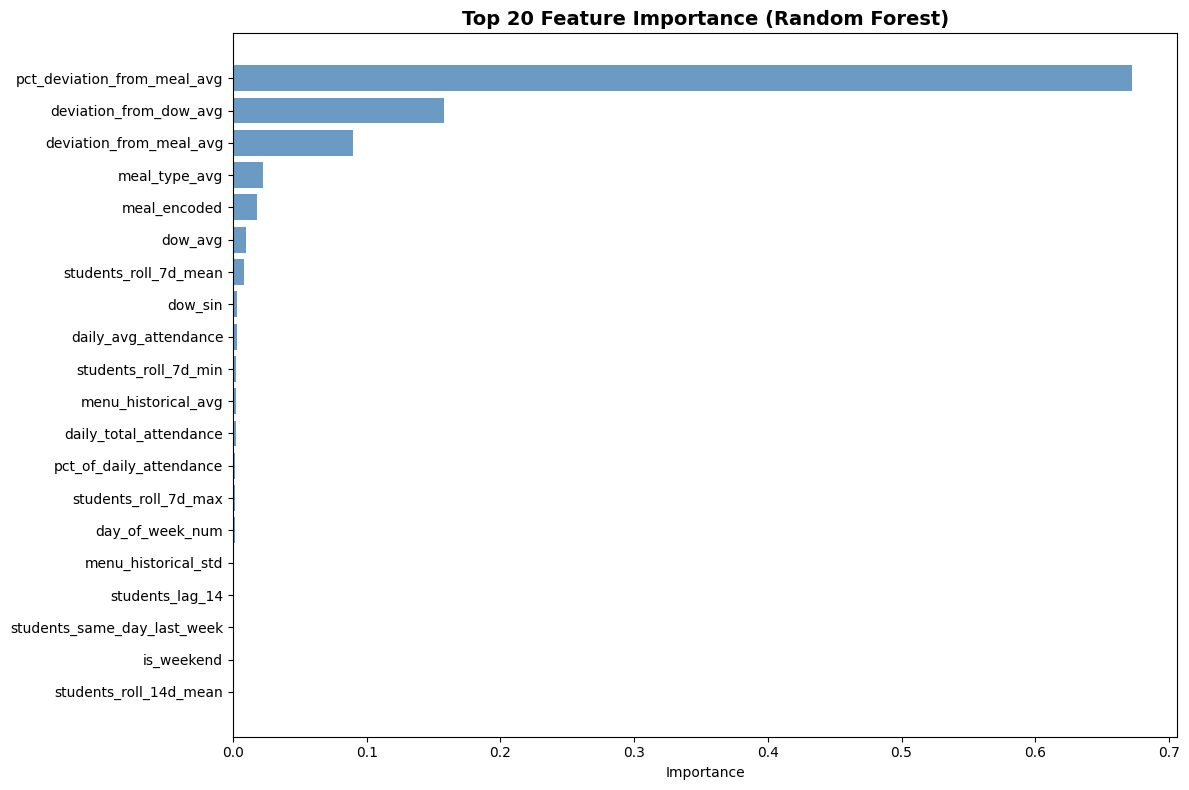


💡 These features will be most useful for prediction!


In [14]:
# ============================================
# CELL 14: FEATURE IMPORTANCE PREVIEW (Quick Check)
# ============================================

print("\n" + "="*60)
print("QUICK FEATURE IMPORTANCE CHECK")
print("="*60)

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Prepare data for quick model
df_model = df.copy()

# Encode categorical columns
le_meal = LabelEncoder()
le_weather = LabelEncoder()

df_model['meal_encoded'] = le_meal.fit_transform(df_model['meal_type'])
df_model['weather_encoded'] = le_weather.fit_transform(df_model['weather'])

# Select features (exclude target and non-numeric)
exclude_cols = ['students_attended', 'date', 'menu_item', 'day_of_week', 
                'weather', 'meal_type', 'week_year', 'food_prepared_kg', 
                'food_consumed_kg', 'food_wasted_kg', 'waste_percentage',
                'total_cost_rs', 'waste_cost_rs', 'attendance_rate']

feature_cols = [col for col in df_model.columns if col not in exclude_cols]

X = df_model[feature_cols]
y = df_model['students_attended']

# Quick RF model to see feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X, y)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🏆 Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='steelblue', alpha=0.8)
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n💡 These features will be most useful for prediction!")

In [15]:
# ============================================
# CELL 15: NEXT STEPS
# ============================================

print("\n" + "="*80)
print("✅ FEATURE ENGINEERING COMPLETE!")
print("="*80)

print("\n📊 What we created:")
print(f"   • Started with: {original_features} features")
print(f"   • Created: {new_features} new features")
print(f"   • Total features: {len(df.columns)}")
print(f"   • Final dataset: {len(df)} rows")

print("\n📁 Files saved:")
print("   ✓ data/processed/mess_data_with_features.csv")
print("   ✓ data/processed/feature_names.txt")

print("\n🎯 Next Steps:")
print("   1. Create modeling notebook (03_modeling.ipynb)")
print("   2. Train-test split")
print("   3. Scale features")
print("   4. Train baseline models")
print("   5. Hyperparameter tuning")
print("   6. Evaluate on test set")
print("   7. Deploy best model")

print("\n" + "="*80)


✅ FEATURE ENGINEERING COMPLETE!

📊 What we created:
   • Started with: 28 features
   • Created: 51 new features
   • Total features: 79
   • Final dataset: 852 rows

📁 Files saved:
   ✓ data/processed/mess_data_with_features.csv
   ✓ data/processed/feature_names.txt

🎯 Next Steps:
   1. Create modeling notebook (03_modeling.ipynb)
   2. Train-test split
   3. Scale features
   4. Train baseline models
   5. Hyperparameter tuning
   6. Evaluate on test set
   7. Deploy best model

